In [1]:
#THIS PROGRAM DEMONSTRATES HODGKIN HUXLEY MODEL IN CURRENT CLAMP EXPERIMENTS AND SHOWS ACTION POTENTIAL PROPAGATION
#Time is in secs, voltage in mvs, conductances in m mho/mm^2, capacitance in uF/mm^2

# threshold value of current is 0.0223


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

In [13]:
ImpCur=0.451 #change input current here
g_K_max=.36 # max conductance of K channel
V_K=-77 #voltage of K channel
g_Na_max=1.20 #max conductance of Na channel
V_Na=50 #voltage of Na channel
g_l=0.003 #conductance of combined gates
V_l=-54.387 #voltageof combined channel
cm=.01 

dt=0.01 #0.01 ms
niter=10000
t=np.array([i for i in range(niter)])
I_app=ImpCur*np.ones(niter)
V=-64.9964 #base voltage
m=0.0530
h=0.5960
n=0.3177


#### to store the values
g_Na_hist=np.zeros(niter)
g_K_hist=np.zeros(niter)
V_hist=np.zeros(niter)
m_hist=np.zeros(niter)
h_hist=np.zeros(niter)
n_hist=np.zeros(niter)

for i in range(niter):
    g_Na = g_Na_max*(m**3)*h
    g_K = g_K_max*(n**4)
    g_total = g_Na+g_K+g_l
    V_inf = ((g_Na*V_Na+g_K*V_K+g_l*V_l)+I_app[i])/g_total
    tau_v = cm/g_total
    V = V_inf+(V- V_inf)*np.exp(-dt/tau_v)
    alpha_m = 0.1*(V+40)/(1-np.exp(-(V+40)/10))
    beta_m = 4*np.exp(-0.0556*(V+65))
    alpha_n = 0.01*(V+55)/(1-np.exp(-(V+55)/10))
    beta_n = 0.125*np.exp(-(V+65)/80)
    alpha_h = 0.07*np.exp(-0.05*(V+65))
    beta_h = 1/(1+np.exp(-0.1*(V+35)))
    tau_m = 1/(alpha_m+beta_m)
    tau_h = 1/(alpha_h+beta_h)
    tau_n = 1/(alpha_n+beta_n)
    m_inf = alpha_m*tau_m
    h_inf = alpha_h*tau_h
    n_inf = alpha_n*tau_n
    m=m_inf+(m-m_inf)*np.exp(-dt/tau_m)
    h=h_inf+(h-h_inf)*np.exp(-dt/tau_h)
    n=n_inf+(n-n_inf)*np.exp(-dt/tau_n)
    V_hist[i]=V
    m_hist[i]=m 
    h_hist[i]=h 
    n_hist[i]=n
    
def plot_V_vs_t(V_hist,I_ext):    
    plt.plot(t*dt,V_hist)
    plt.grid()
    plt.title('Voltage vs Time for I=%f $\mu$A'%I_ext)
    plt.xlabel('time in msec')
    plt.ylabel('Voltage in mV')
    plt.show()
    
def plot_gating_variables(m_hist,h_hist,n_hist,I_ext):
    plt.plot(t*dt,m_hist,'y',label='m')
    plt.plot(t*dt,h_hist,'g',label='h')
    plt.plot(t*dt,n_hist,'b',label='n')
    plt.xlabel('Time in msec')
    plt.title('Gating variables for I=%f $\mu$A'%I_ext)
    plt.grid()
    plt.legend()
    plt.show()

def plot_conductances(m_hist,h_hist,n_hist,I_ext):
    g_Na=g_Na_max*(m_hist**3)*h_hist
    g_K=g_K_max*n_hist**4
    plt.plot(t*dt,g_Na,'r',label='g_Na')
    plt.plot(t*dt,g_K,'b',label='g_K')
    plt.title('Conductances for I=%f $\mu$A'%I_ext)
    plt.legend()
    plt.grid()
    plt.show()

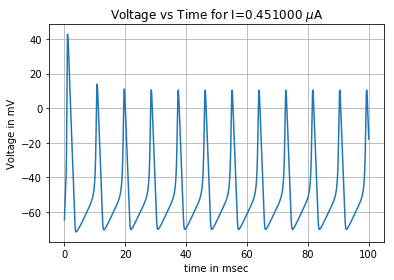

In [14]:
plot_V_vs_t(V_hist,ImpCur)

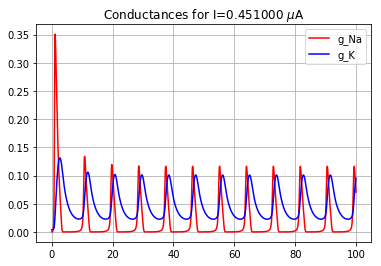

In [15]:
plot_conductances(m_hist,h_hist,n_hist,ImpCur)

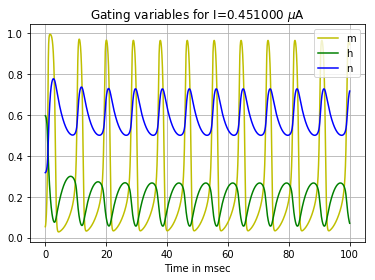

In [16]:
plot_gating_variables(m_hist,h_hist,n_hist,ImpCur)

In [24]:
def peakdet(v, delta, x = None):
    """
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

maxtab, mintab = peakdet(V_hist,.3)


In [25]:
# to plot the frequency curve
I_ext=np.linspace(0.0623,0.451,100)
peak_num=[]
dt=0.01 #0.01 ms
niter=100000
t=np.array([i for i in range(niter)])
for j in tqdm(range(len(I_ext))):
    ImpCur=I_ext[j]
    I_app=ImpCur*np.ones(niter)
    #### to store the values
    g_Na_hist=np.zeros(niter)
    g_K_hist=np.zeros(niter)
    V_hist=np.zeros(niter)
    m_hist=np.zeros(niter)
    h_hist=np.zeros(niter)
    n_hist=np.zeros(niter)
    for i in range(niter):
        g_Na = g_Na_max*(m**3)*h
        g_K = g_K_max*(n**4)
        g_total = g_Na+g_K+g_l
        V_inf = ((g_Na*V_Na+g_K*V_K+g_l*V_l)+I_app[i])/g_total
        tau_v = cm/g_total
        V = V_inf+(V- V_inf)*np.exp(-dt/tau_v)
        alpha_m = 0.1*(V+40)/(1-np.exp(-(V+40)/10))
        beta_m = 4*np.exp(-0.0556*(V+65))
        alpha_n = 0.01*(V+55)/(1-np.exp(-(V+55)/10))
        beta_n = 0.125*np.exp(-(V+65)/80)
        alpha_h = 0.07*np.exp(-0.05*(V+65))
        beta_h = 1/(1+np.exp(-0.1*(V+35)))
        tau_m = 1/(alpha_m+beta_m)
        tau_h = 1/(alpha_h+beta_h)
        tau_n = 1/(alpha_n+beta_n)
        m_inf = alpha_m*tau_m
        h_inf = alpha_h*tau_h
        n_inf = alpha_n*tau_n
        m=m_inf+(m-m_inf)*np.exp(-dt/tau_m)
        h=h_inf+(h-h_inf)*np.exp(-dt/tau_h)
        n=n_inf+(n-n_inf)*np.exp(-dt/tau_n)
        V_hist[i]=V
        m_hist[i]=m 
        h_hist[i]=h 
        n_hist[i]=n
    maxtab, mintab = peakdet(V_hist,.3)
    peak_num.append(len(maxtab)-1)

100%|██████████| 100/100 [06:11<00:00,  4.01s/it]


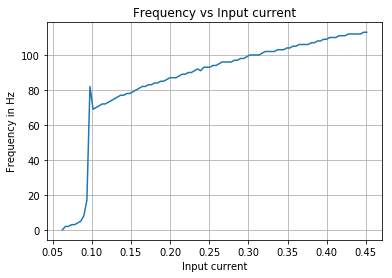

In [26]:
plt.plot(I_ext,np.array(peak_num)+1)
plt.grid()
plt.title('Frequency vs Input current in region 3')
plt.xlabel('Input current')
plt.ylabel('Frequency in Hz')
plt.show()